In [1]:
from genderize import Genderize #ran out 1000 names :(
import pandas as pd
import numpy as np
import random
import gender_guesser.detector as gender 

In [2]:
detector = gender.Detector()

In [3]:
_df = pd.read_csv("sampleTable.csv") # read csv file as dataframe

In [4]:
_df.head()

,pub_id,first_name,last_name,aff_country,aff_country_code,aff_id,aff_city,aff_city_id,gender
0,pub.1123345821,Jake,Peralta,United States,US,21345,New York City,45378,male
1,pub.1123345821,Amy,Santiago,Cuba,CU,72490,Havana,90182,female
2,pub.1123345821,Ray,Holt,United States,US,21345,New York City,45378,male
3,pub.1123345821,Rosa,Diaz,United States,US,21345,Houston,12456,female
4,pub.1123345821,Charles,Boyle,United States,US,21345,New York City,45378,male


In [9]:
class Author(object):
    def __init__(self, paper, first, last, country, country_code, aff_city, gender): 
        self.firstName = first 
        self.lastName = last 
        self.country = country
        self.country_code = country_code
        self.city = aff_city 
        #self.gender = detector.get_gender(first + last)
        self.gender = gender
        self.paperList = []
        self.paperList.append(paper) 

    def __eq__(self, other):
        if (isinstance(other, Author)): 
            return (self.firstName == other.firstName and self.lastName == other.lastName and self.gender == other.gender and self.country_code and other.country_code)
        else: 
            return False 

    def __hash__(self):
        return(hash(self.firstName + self.lastName))

    def display(self): 
        print("Author: " + self.firstName + " " + self.lastName + " from " + self.city + ", " + self.country + "(" + self.gender + ")")
    
    def getName(self):
        return self.firstName + " " + self.lastName 
      

In [10]:
def collectAuthorsOfOnePaper(df, pub_id, start_point, **kwargs):
    refAuthor = kwargs.get('refAuthor', None)
    authorList = []
    for index, row in df[start_point:].iterrows(): 
        if (row["pub_id"] == pub_id): 
            author = Author(
                row["pub_id"], 
                row["first_name"], 
                row["last_name"],
                row["aff_country"], 
                row["aff_country_code"], 
                row["aff_city"], 
                row["gender"]
            )
            if (author != refAuthor):
                authorList.append(author)
        else:
            break
    return authorList

In [11]:
# Function will search dataframe for the specific author object entered. Identified through first and last name property. 
# Use collectAuthorsOfOnePaper method to create this list 

def searchAuthorPapers(df, author):
    paperDict = {} # Dictionary of an author's papers. Each key is a publication ID, each value is a list of collaborators for that paper  
    collectionStartPoint = -1 # Tells which row the publication ID begins in df.
    previousPaperID = "" # Notifies when the publication changes -- Updates collectionStartPoint
    for index, row in df.iterrows():
        if(row["pub_id"] != previousPaperID):
            previousPaperID = row["pub_id"]
            collectionStartPoint = index
        if row['first_name'] == author.firstName and row['last_name'] == author.lastName and row['aff_country'] == author.country:
            pub_id = row['pub_id'] # key
            authorList = collectAuthorsOfOnePaper(df, pub_id, collectionStartPoint, refAuthor=author)
            pub_id = pub_id.replace("pub.", "")
            pub_id = int(pub_id)
            paperDict[pub_id] = authorList
    return paperDict

In [12]:
authorList = collectAuthorsOfOnePaper(_df, "pub.1123345821", 0) 

In [13]:
print(len(authorList))

5


In [14]:
for author in authorList:
    print(author.getName())

Jake Peralta
Amy Santiago
Ray Holt
Rosa  Diaz
Charles Boyle


In [16]:
x = searchAuthorPapers(_df, authorList[4])

In [17]:
x.keys()

dict_keys([1123345821, 3458903457])

In [18]:
print(x.values())

dict_values([[<__main__.Author object at 0x7a1781211710>, <__main__.Author object at 0x7a1781210990>, <__main__.Author object at 0x7a1781213110>, <__main__.Author object at 0x7a1781213c50>], [<__main__.Author object at 0x7a1781048810>, <__main__.Author object at 0x7a1781211b10>, <__main__.Author object at 0x7a1781213810>, <__main__.Author object at 0x7a1781049d10>, <__main__.Author object at 0x7a1781210fd0>, <__main__.Author object at 0x7a17810486d0>, <__main__.Author object at 0x7a1781048510>]])


In [19]:
# In this example we can see multiple papers of a single author can be found and sorted
# If someone collected multiple csvs of different authors to see how much they collaborate, we can get that information

In [20]:
count = 0
keys = x.keys()
for publication in keys:
    print(publication)
    for author in x[publication]: 
        print(author.getName())
    count+=1
    print()

1123345821
Jake Peralta
Amy Santiago
Ray Holt
Rosa  Diaz

3458903457
Jake Peralta
Rosa  Diaz
Víctor Doménech-García
Yutian Ji
Qianhui Xu
Shukun Liu
Yuanshi Wang



In [21]:
authorList[4].display()

Author: Charles Boyle from New York City, United States(male)


In [22]:
# Visualizations of dictionary using graph
import matplotlib.pyplot as plt
import networkx as nx

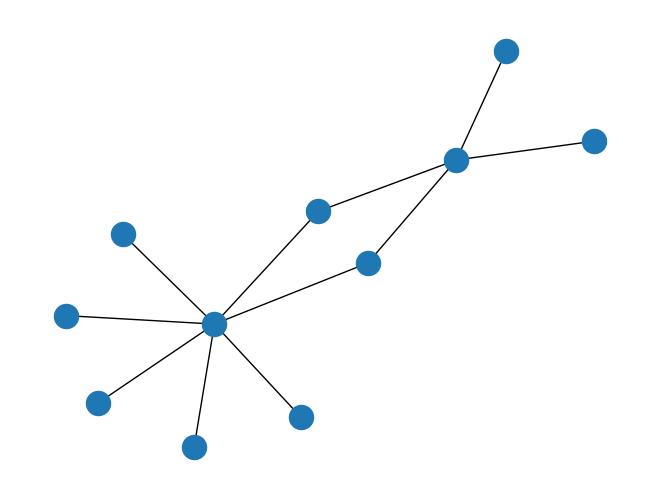

In [23]:
G = nx.from_dict_of_lists(x)
nx.draw(G)
plt.show()

In [25]:
# Each author gets their own unique node (due to eq and hash functions)
# We can see the number of times an author has collaborated with the main author
count = 0
for node in G.nodes:
    count += 1
    #print("Count: " + str(count))
    if isinstance(node, Author):
        print(node.getName())
        print(G.degree[node])
    else:
        print(node)

1123345821
3458903457
Jake Peralta
2
Amy Santiago
1
Ray Holt
1
Rosa  Diaz
2
Víctor Doménech-García
1
Yutian Ji
1
Qianhui Xu
1
Shukun Liu
1
Yuanshi Wang
1


# Determining the index... 

## Paper-based features

 **Gender: 1/(% of gender)**<br>
 Ex: 4/7 F, 3/7 M.  <br>
- Each male will get 7/3 = 2.33, Each female get 7/4 = 1.42 apply a round function, each male gets 2, each female gets 1. <br>
 This is because this paper in particular is partially female dominated, thus making the male perspective slightly more valuable
 
 Ex: 1/7 F, 6/7 M: 
 - The female gets a score of 7, the male get 7/6 or 1.16 which rounds to 1. In this case to balance the genders the females perspective is 7 times as valuable in order for equal gender diversity.  

 This rewards people for joining papers in which they are less represented. <br>                                                             This rewards people who reach out to people they might not normally work with.
 
 **Nationality:** <br>
 Due to difficulty in working with people from far away, irrationality in close level studies + language barriers (privilege of English       speakers == boosted score), this is hard to quantify.
 <br>
 For now I will add it as a bonus factor. Should be a togglable feature. 
 <br>
 For each unique country add 1 * weight -- weight calculation based on number of authors to keep scale relatively small, this way
 nationality will not overly outweigh gender in paper-based calculations


## Cross-paper features
 **n times collaborated with** <br>
 Each paper appearance will cause the affect of their appearance to decrease by __20% across all papers every 3 shared appearances__ <br>
 Any paper-based calculation dependent on a repeat author will essentialy be reduced 20% for their overall effect to be mitigated. <br>
 This reduction is used to encourage new collaboration over time. If the same "diverse group" continues to meet, the ideas are no longer diverse


## Result
 Calculate each paper individually as gender feature + nationality bonus depend on the # of authors
 Any author with a degree greater than or equal to three is kept track of in a list
 
## Future paper-based metrics
 - University Ranking
 - Departments

In [26]:
def calculateDIndex(author, collabDict, collabGraph, minRepeats = 3, repeatCost = 0.2):
    paperFeatureIndices = []
    for publication in collabDict.keys():
        genderFactor = 1 # for original author
        nationalityBonus = 0
        nationalityList = []
        for collab in collabDict[publication]:
            cost = 1 
            if collabGraph.degree[collab] >  minRepeats: 
                cost = (1 - repeatCost)
            if author.gender == collab.gender: 
                genderFactor+=(1*cost)
            nationalityList.append(collab.country_code)
            nationalityBonus += len(set(nationalityList)) # Get number of unique values TODO: ADD WEIGHT BASED ON NUMBER OF AUTHORS
            #print(genderFactor)
        genderFactor = round(1/(genderFactor/len(collabDict[publication])))
        print(genderFactor)
        print(nationalityBonus)
        paperFeatureIndices.append(genderFactor + nationalityBonus)

    return sum(paperFeatureIndices)/len(paperFeatureIndices) 

In [27]:
count = 0
keys = x.keys()
for publication in keys:
    print(publication)
    for author in x[publication]: 
        author.display()
    count+=1
    print()

1123345821
Author: Jake Peralta from New York City, United States(male)
Author: Amy Santiago from Havana, Cuba(female)
Author: Ray Holt from New York City, United States(male)
Author: Rosa  Diaz from Houston, United States(female)

3458903457
Author: Jake Peralta from New York City, United States(male)
Author: Rosa  Diaz from Houston, United States(female)
Author: Víctor Doménech-García from Zaragoza, Spain(male)
Author: Yutian Ji from Hangzhou, China(male)
Author: Qianhui Xu from Shanghai, China(female)
Author: Shukun Liu from Singapore, Singapore(female)
Author: Yuanshi Wang from Sheffield, United Kingdom(female)



In [28]:
index = calculateDIndex(authorList[4], x, G, minRepeats=1) # Calculate index for one author 

1
7
2
19


In [29]:
print(index)

14.5
